# Camille Girard Think Bayes Homework 4

This notebook presents example code and exercise solutions for Think Bayes.

Camille Girard

MIT License: https://opensource.org/licenses/MIT

In [62]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Suite, Beta, MakeGammaPmf, MakeJoint, Joint
import thinkbayes2

import matplotlib.pyplot as plt
import thinkplot
import pandas as pd
import numpy as np
from scipy.stats import norm, hypergeom
import math
from thinkbayes2 import MakePoissonPmf

class BayesTable(pd.DataFrame):
    def __init__(self, hypo, prior=1):
        columns = ['hypo', 'prior', 'likelihood', 'unnorm', 'posterior']
        super().__init__(columns=columns)
        self.hypo = hypo
        self.prior = prior
    
    def mult(self):
        self.unnorm = self.prior * self.likelihood
        
    def norm(self):
        nc = np.sum(self.unnorm)
        self.posterior = self.unnorm / nc
        return nc
    
    def update(self):
        self.mult()
        return self.norm()
    
    def reset(self):
        return BayesTable(self.hypo, self.posterior)

ERROR:root:The 'ast_node_interactivity' trait of a ZMQInteractiveShell instance must be any of ['all', 'last', 'last_expr', 'none'], but a value of 'last_expr_or_assign' <class 'str'> was specified.


# One More Height Problem

In a room of 10 randomly chosen U.S. residents, A is the second tallest.  How tall is A?  What is the probability that A is male?

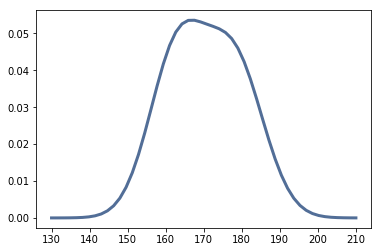

In [63]:
dist_height = dict(male=norm(178, 7.7), female=norm(163, 7.3))
heights = np.linspace(130, 210)
prob_m = dist_height['male'].pdf(heights)
prob_f = dist_height['female'].pdf(heights)
m_pmf = Pmf(dict(zip(heights, prob_m)))
f_pmf = Pmf(dict(zip(heights, prob_f)))
metapmf = Pmf([m_pmf,f_pmf])
mix = thinkbayes2.MakeMixture(metapmf)
thinkplot.Pdf(mix)

In [64]:
class Height(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: who is taller, 'A' or 'B'?
        hypo: h1, h2
        """
        h1, h2 = hypo
        if data == 'A':
            return 1 if h1 > h2 else 0
        else:
            return 1 if h2 > h1 else 0

def make_prior(A, B):
    suite = Height()

    for h1, p1 in A.Items():
        for h2, p2 in B.Items():
            suite[h1, h2] = p1 * p2
    return suite

In [65]:
A = mix
B = mix
def taller(person1, person2, difference):
    joint = make_prior(person1, person2)
    joint.Update(difference)
    return joint.Marginal(0), joint.Marginal(1)

In [66]:
for i in range(8):
    A, _ = taller(A, B, 'A')
    
A, B = taller(A, B, 'B');

181.74226142591198

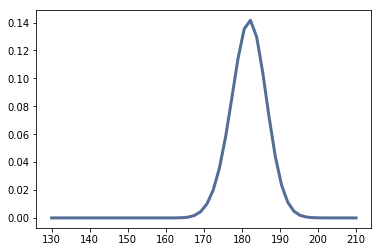

In [67]:
thinkplot.Pdf(A)
A.Mean()

In [68]:
class H(Suite): 
    def Likelihood(self, data, hypo):
        """
        data: height in cm
        hypo: 'male' or 'female'
        """
        height = data
        return dist_height[hypo].pdf(height)
    
def prob_male(height):
    suite = H(dict(male=0.49, female=0.51))
    suite.Update(height)
    return suite['male']

In [69]:
male_prob = 0
for h, prob in A.Items():
    male_prob += prob * prob_male(h)
male_prob

0.9197862123801361

# Lincoln Index Problem

Read How many errors are left to find?, and write a Bayesian solution to this problem:

Suppose two testers independently search for bugs. Let k1 be the number of errors the first tester finds and k2 the number of errors the second tester finds. Let c be the number of errors both testers find.  [I changed Cook's notation to be consistent with mine].

For concreteness, suppose the first tester finds 20 bugs, the second finds 15, and they find 3 in common.

Compare your solution to the Lincoln Index, which estimates the total number of errors as k1 k2 / c.

(110.0, 100)

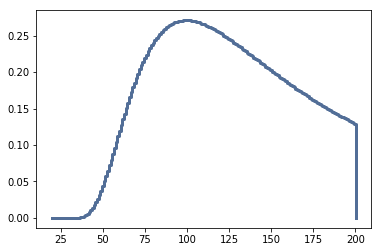

In [70]:
prb = hypergeom.pmf(3,range(20,201),20,15);
x = np.arange(20,201);

bugs = Pmf();

for i in range(0,181):
    pred = i + 20
    bugs[pred] = prb[i]

thinkplot.Pmf(bugs)
np.mean(bugs), bugs.MAP()

In [71]:
lincoln = (20*15)/3
lincoln

100.0

# The Skeet Problem

At the 2016 Summer Olympics in the Women's Skeet event, Kim Rhode faced Wei Meng in the bronze medal match. They each hit 15 of 25 skeets, sending the match into sudden death. In the first round, both hit 1 of 2 skeets. In the next two rounds, they each hit 2 skeets. Finally, in the fourth round, Rhode hit 2 and Wei hit 1, so Rhode won the bronze medal, making her the first Summer Olympian to win an individual medal at six consecutive summer games.

But after all that shooting, what is the probability that Rhode is actually a better shooter than Wei? If the same match were held again, what is the probability that Rhode would win?

As always, you will have to make some modeling decisions, but one approach is to estimate, for each shooter, the probability of hitting a skeet. Then, to estimate the probability that Rhode is a better shooter, you can draw samples from the two posterior distributions and compare them. To estimate the probability of winning a rematch, you could draw samples from the posterior distributions and simulate a round of 25 shots.

In [72]:
Rhode = Beta(1,1)
Rhode.Update((22,11))
Wei = Beta(1,1)
Wei.Update((21,12))

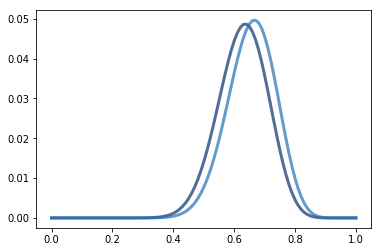

In [73]:
thinkplot.Pdf(Wei.MakePmf())
thinkplot.Pdf(Rhode.MakePmf())

In [74]:
# Is Rhodes Better?
r_sample = Rhode.MakeCdf(1000000).Sample(1000000)
w_sample = Wei.MakeCdf(1000000).Sample(1000000)
r_better = np.mean(r_sample > w_sample)
r_better

0.600456

Once the shots are taken into account with an even prior the probability of Rhodes being a better skeet shooter than Wei is between 59 and 60 percent - closer to 60

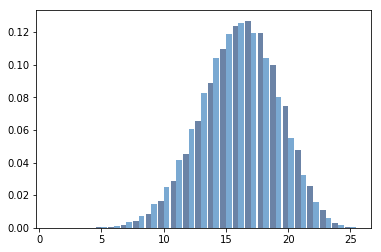

In [75]:
r_rematch = np.random.binomial(25, r_sample)
w_rematch = np.random.binomial(25,w_sample)
thinkplot.Hist(Pmf(r_rematch), width=0.45, align='right')
thinkplot.Hist(Pmf(w_rematch), width=0.45, align='left')

In [76]:
#Will Rhodes win a rematch?
r_win = np.mean(r_rematch > w_rematch)
r_tie = np.mean(r_rematch == w_rematch)
r_lose = np.mean(r_rematch < w_rematch)
r_win, r_tie, r_lose

(0.520108, 0.089365, 0.390527)

Rhodes has a 52 percent chance of winning a rematch against Wei and a 9 percent chance of a tie (meaning 39 percent chance of losing)

# The Social Desireability Problem

Whenever you survey people about sensitive issues, you have to deal with social desirability bias, which is the tendency of people to shade their answers in the direction they think shows them in the most positive light.

One of the ways to improve the quality of the results is to collect responses in indirect ways.  For example, here's a clever way one research group estimated the prevalence of atheists.

Another way is "randomized response", as described in this article or this video (if you can stand it).

As an example, suppose you ask 100 people to flip a coin and:

If they get heads, they report YES.
If they get tails, then honestly answer the question "Do you believe in God?"

And suppose you get 80 YESes and 20 NOs.

Estimate the prevalence of atheists in the surveyed population (by which, as always, I mean compute a posterior distribution).


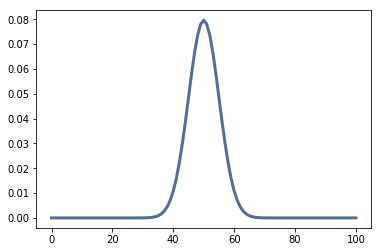

In [77]:
binomial = thinkbayes2.MakeBinomialPmf(100, 0.5)
thinkplot.plot(binomial)

In [83]:
class trial(Suite): 
    def Likelihood(self, data, hypo):
        """
        hypo : who believes in god
        data : how many said yes 
        """
        total = 0
        for num, p in binomial.Items():
            if data < num:
                total += 0
            else:
                fraction = (data - num) / (100-num)
                if round(fraction * 100)== hypo:
                    total += p
                else:
                    total += 0
        return total

(62, 59.61545373512311)

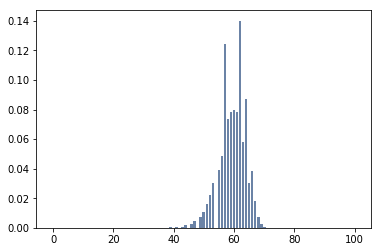

In [84]:
people = trial(range(0,101))
people.Update(80)
thinkplot.Hist(people)
people.MAP(), people.Mean()

# Volunteer Problem

This comes from a participant at a Bayesian workshop I ran years ago:

"A group of people sign up to do a community service project.  Some fraction of them actually participate, and then some fraction of the participants report back to confirm.  In other words, some of the people who sign up don't participate, and some of the people that participate don't report back.

Given the number of people who sign up and the number of people who report back, can we estimate the number of people who actually participated?"

One way to model this scenario is to say that each person who signs up has a probability, q, of participating and a probability, r, of reporting back.  (Let's assume that if someone does not participate, they don't report that they did.) 

Suppose 140 people sign up and only 50 report back.  With this data we can compute posterior distributions for q and r, but we can't distinguish between them.

But support we call 5 people who signed up and learn that 3 of them participated and 1 reported back.  How can we combine the data from these two sources to estimate the distributions of q and r?

And how do we use those distributions to estimate the number of people who participated?

In [16]:
class volunteer(Suite):
    def Likelihood(self,data,hypo):
        if len(data) == 2:
            return self.Likelihood_a(data,hypo)
        elif len(data) ==3:
            return self.Likelihood_b(data,hypo)
    def Likelihood_a(self,data,hypo):
        q, r = hypo
        p = q*r
        sign, report = data
        yes = report
        no = sign - report 
        like = p**yes * (1-p)**no
        return like
    def Likelihood_b(self,data,hypo):
        q,r = hypo
        sign, participate, report = data
        yes = participate
        no = sign - participate
        like_a = q**yes * (1-q)**no
        yes2 = report
        no2 = participate - report
        like_b = r**yes * (1-r)**no
        return like_a*like_b

In [17]:
probs = np.linspace(0,1,101)
hypos = []
for q in probs:
    for r in probs:
        hypos.append((q,r))
vol = volunteer(hypos)
data1 = 140,50
data2 = 5,3,1
vol.Update(data1)
vol.Update(data2);

In [18]:
q = thinkbayes2.Pmf()
r = thinkbayes2.Pmf()
for t, prob in vol.Items():
    q.Incr(t[0],prob)
    r.Incr(t[1],prob)

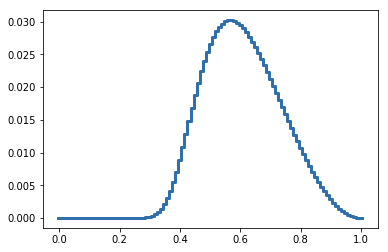

In [19]:
thinkplot.Pmf(q, label='q')
thinkplot.Pmf(r, label = 'r')

In [20]:
total = 0
for p,prob in q.Items():
    total += 140*p*prob
total

84.924835886342

# Project Ideas

### Trees
   
A problem could be around the idea of age of a tree based on size instead of by ring. This could include developing distributions based on tree size and on age of the tree based on the opposite using the data. Data from other trees could be collected and could use the distributions to find the age. The trees would have to be from the same species.

Data : https://dasl.datadescription.com/datafile/how-old-is-that-tree/?_sf_s=tree&_sfm_cases=4+59943


### Crocodile Lengths

A problem using the length of the body and the head of an animal and a dataset to make a distribution to find which species the crocidile is likely from. 

Data: https://dasl.datadescription.com/datafile/crocodile-lengths/?_sf_s=animal&_sfm_cases=4+59943